# LRpS + GES: Causal structure estimation in the presence of some hidden variables

Here we reproduce some of the plots found in $\S5$ of "Robust Causal Structure Learning with Hidden Variables" (https://rss.onlinelibrary.wiley.com/doi/10.1111/rssb.12315) .

The idea is to first estimate an inverse covariance matrix from which the effect of hidden variables has been subtracted and then to use the GES algorithm on the resulting covariance matrix so as to infer a DAG structure. The IDA algorithm can then also be used to estimate multisets of potential causal effects. 


We will:
-  Generate data according to a Directed Acyclic graph with latent variables.
-  Perform cross-validation with LRpS so as to select $\gamma$ and $\lambda$.
-  Use the resulting $\hat{S}$ as input to the GES algorithm.
-  Run IDA in order to estimate multisets of causal effects.

A useful reference is *Causal Inference Using Graphical Models with the R Package `pcalg`* (https://www.jstatsoft.org/article/view/v047i11).


In order to run GES and IDA, you also need to install the PCALG package. This package is on CRAN but also has dependencies on bioconductor, so you might need to install other packages (e.g. RBGL) yourself from bioconductor. This is really straightforward and you can follow instructions, e.g. here: https://www.bioconductor.org/packages/release/bioc/html/RBGL.html .
## Prerequisites

Here are the packages used in this tutorial

In [18]:
#install.packages(c("pcalg", "bnlearn", "igraph"))
library(pcalg)
library(bnlearn)
library(mvtnorm)
library(lrpsadmm)
library(ggplot2)

## Generate data from a DAG with latent variables

In [19]:
source("./utils/simulate_data_from_latent_dag.R")
p <- 50 # Number of obvserved variables 
h <- 3 # Number of hidden variables
n <- 500 # Number of samples
set.seed(0)
toy.data <- simulate.latent.DAG.data(nl = h, nv = p, ss = n, sp = 0.05)
X <- toy.data$data # The observed data
X <- scale(X)

## Compute LRpS and select a graphical model using cross-validation

We start by estimating $\hat{S}, \hat{L}$ using 5-fold cross-validation.

In [21]:
gammas <- c(0.05, 0.07, 0.1, 0.12, 0.15, 0.17, 0.2)
xval.path <- lrpsadmm.cv(X = X, gammas = gammas, covariance.estimator = cor, n.folds = 5, 
                         verbose = TRUE, n.lambdas = 40, lambda.ratio=1e-04, backend='R')

[1] "### Computing the path on the full dataset first ###"
[1] "Fitting with gamma= 0.05  and lambda= 18.0179534646122 Sparsity: 0 Rank of L: 0"
[1] "Fitting with gamma= 0.05  and lambda= 14.3121691688896 Sparsity: 0.00653061224489796 Rank of L: 0"
[1] "Fitting with gamma= 0.05  and lambda= 11.3685600709994 Sparsity: 0.0146938775510204 Rank of L: 1"
[1] "Fitting with gamma= 0.05  and lambda= 9.0303682525539 Sparsity: 0.0244897959183673 Rank of L: 1"
[1] "Fitting with gamma= 0.05  and lambda= 7.17307647296133 Sparsity: 0.0359183673469388 Rank of L: 1"
[1] "Fitting with gamma= 0.05  and lambda= 5.69777717230965 Sparsity: 0.0489795918367347 Rank of L: 1"
[1] "Fitting with gamma= 0.05  and lambda= 4.52590528313303 Sparsity: 0.0563265306122449 Rank of L: 1"
[1] "Fitting with gamma= 0.05  and lambda= 3.59505435408036 Sparsity: 0.0677551020408163 Rank of L: 1"
[1] "Fitting with gamma= 0.05  and lambda= 2.85565317881449 Sparsity: 0.0914285714285714 Rank of L: 1"
[1] "Fitting with gamma= 0.05  

By plotting the paths, we see when $\gamma$ is too small the computation of the path is stopped early because $\hat{S}$ becomes too dense.

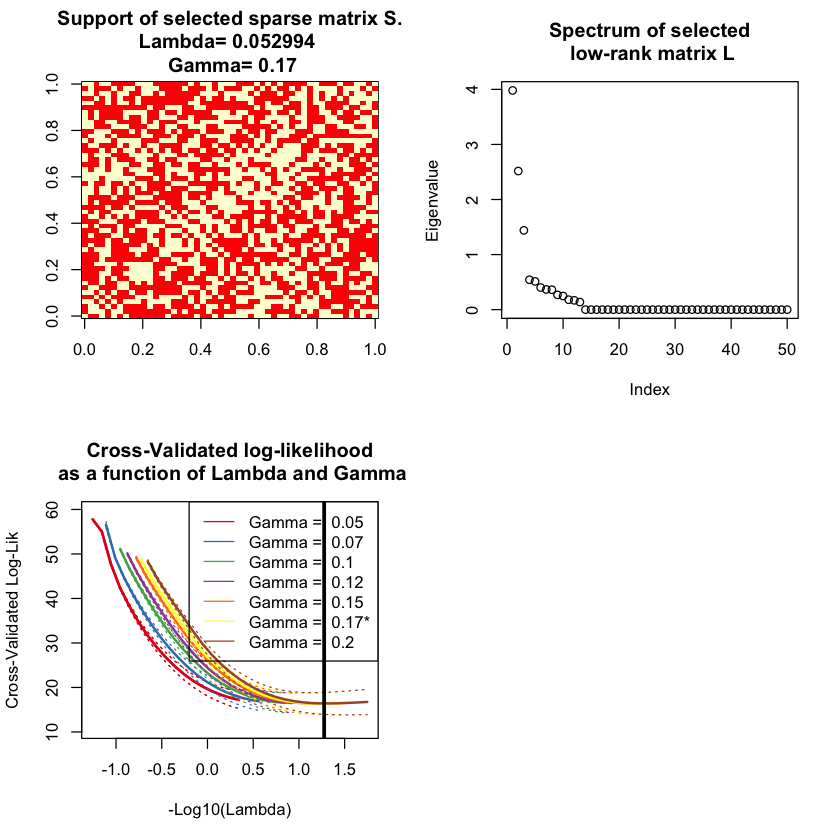

In [22]:
plot(xval.path)

Because the dataset is well-powered and cross-validation has a tendency to overselect, we end up with a rather dense $\hat{S}$:

[1] "Estimated Correlation Matrix"


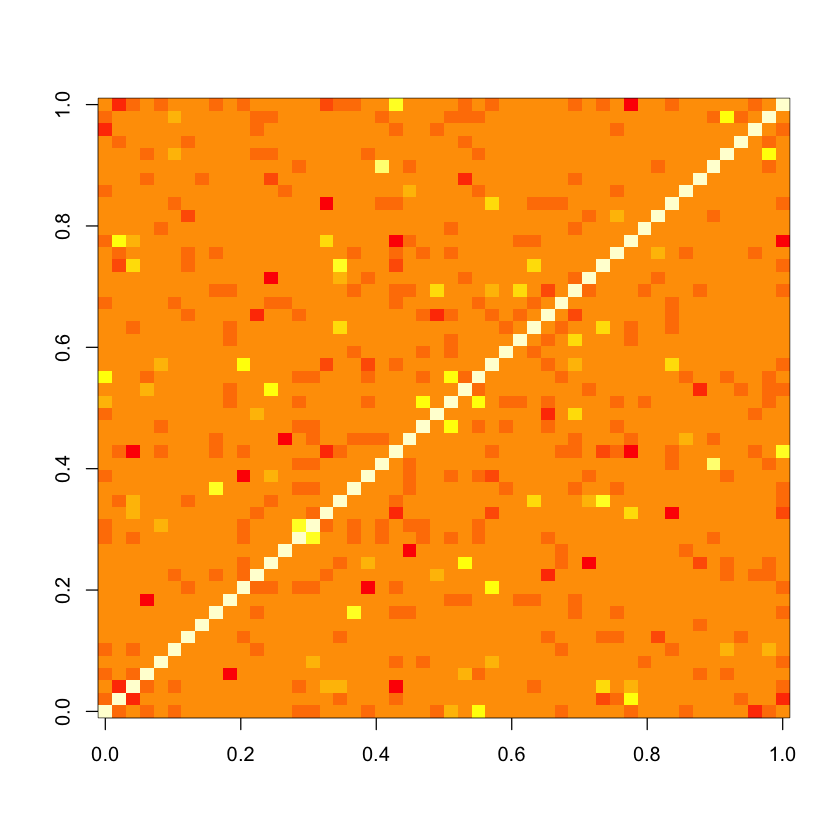

In [23]:
print("Estimated Correlation Matrix")
image(cov2cor(solve(xval.path$best.fit$fit$S)))

## Running GES on the estimated covariance matrix $\hat{S}^{-1}$

Now we can run GES. Because `pcalg`'s implementation only accepts a data matrix as input -- as opposed to a covariance matrix -- we produce "fake data": we transform multivariate normal samples so that they have $\hat{S}^{-1}$ as *sample* covariance matrix. This is simply an implementation trick.

In [24]:
source("./utils/generate_data_for_GES.R")
selected.S <- xval.path$best.fit$fit$S
# Because the GES function of pcalg can only take a data matrix as input and not a covariance matrix, 
# we simulate data with the exact same sample covariance matrix as the estimated one. 
# This is a trick that lets use the GES function of pcalg.
fake.data <- generate.data.for.GES(Sest = selected.S, n=n, p=p)

source("./utils/run_GES.R")
source("./utils/compute_metrics.R")
source("./utils/process_curve.R")

# We now compute the GES path on the resulting data and compute the BIC at each step. 
lrps.ges.output <- run.GES.and.select.with.BIC(obs.data = fake.data, nv = p, sim.data = toy.data)
metrics <- sapply(lrps.ges.output$path, function(a) {get("metric", a)})
idx1 <- which(rownames(metrics) == "prec.sk")
idx2 <- which(rownames(metrics) == "rec.sk")
prec <- unlist(metrics[idx1,])
rec <- unlist(metrics[idx2,])
# The code to process the curve is a bit messy: it simply makes sure that the cure is non decreasing and interpolates
# the precision at fixed values of the recall
lrps.ges.prs.sk <- process_curve(cbind(prec, rec))

In [25]:
# We now compute the GES path on the original dataset, for comparison
ges.output <- run.GES.and.select.with.BIC(obs.data = X, nv = p, sim.data = toy.data)
metrics <- sapply(ges.output$path, function(a) {get("metric", a)})
idx1 <- which(rownames(metrics) == "prec.sk")
idx2 <- which(rownames(metrics) == "rec.sk")
prec <- unlist(metrics[idx1,])
rec <- unlist(metrics[idx2,])
ges.prs.sk <- process_curve(cbind(prec, rec))

Let us compare GES and LRpS + GES in terms of precision / recall. In the following plot, we show how the precision/recall metrics change as the penalty on the number of edges varies. Please see the papers referenced above for more details

Warning message:
“Removed 26 rows containing missing values (geom_path).”

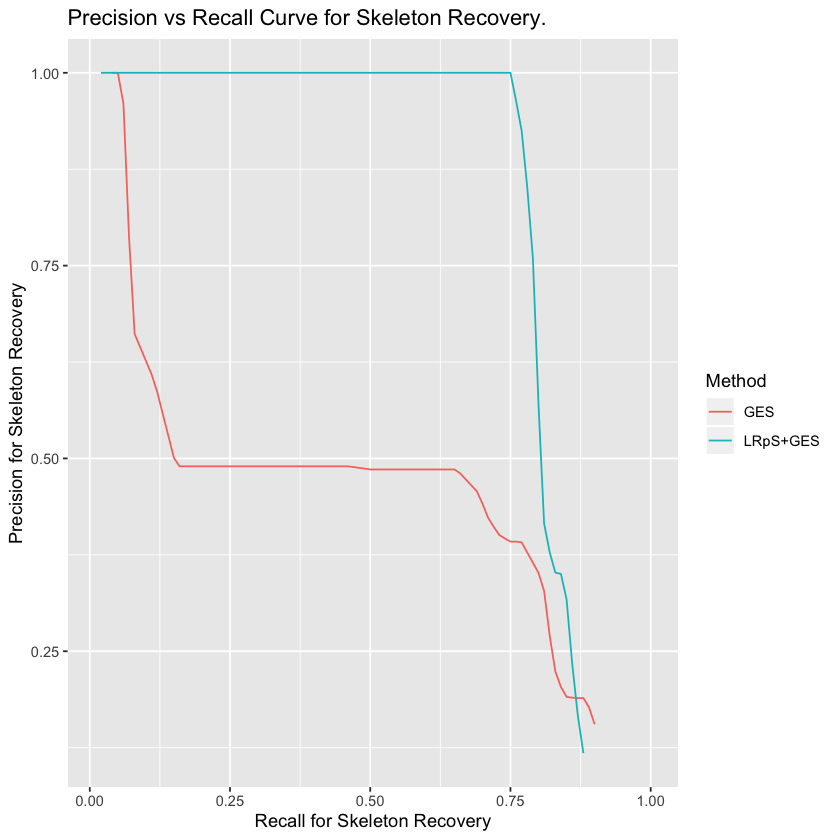

In [26]:
# Plot the results
d <- rbind(as.data.frame(lrps.ges.prs.sk), as.data.frame(ges.prs.sk))
d$Method <- c(rep("LRpS+GES", length(lrps.ges.prs.sk$x)), rep("GES", length(ges.prs.sk$x)))
pl <- ggplot(d, aes(x=x, y=y)) + geom_line(aes(colour=Method)) +
  xlab("Recall for Skeleton Recovery") + ylab("Precision for Skeleton Recovery") +
  ggtitle(paste("Precision vs Recall Curve for Skeleton Recovery."))
pl

## Compute causal effects using IDA

Finally, we select one graph along the GES path using the BIC. For this PCDAG, we use IDA and rank the causal effects. This is compared to the true causal effects.

In [27]:
source("./utils/compute_causal_effects.R")
lrps.ges.ida.results <- compute.causal.effects(selected.S, ges.fit = lrps.ges.output$best.fit,
                       p = p, n = n, dataset=toy.data)

The following step is just for comparison purposes, but it can take time...

In [28]:
# Here, we will compute causal effect on the sample covariance matrix. 
# This use of solve(cor(X)) is nasty and not necessary. This is just to make it work with the 
# function compute.causal.effects.
# This step can be *very slow* because the graph appears very dense due to the latent variables.....
ges.ida.results <- compute.causal.effects(solve(cor(X)), ges.fit = ges.output$best.fit,
                       p = p, n = n, dataset=toy.data)

In [29]:
# The proces_curve function simply process the list of precisions/recalls and makes sure the curve is monotonic etc...
lrps.ges.ida.pr <- process_curve(lrps.ges.ida.results$IDA_prec_red[,c(2,1)])
ges.ida.pr <- process_curve(ges.ida.results$IDA_prec_red[,c(2,1)])

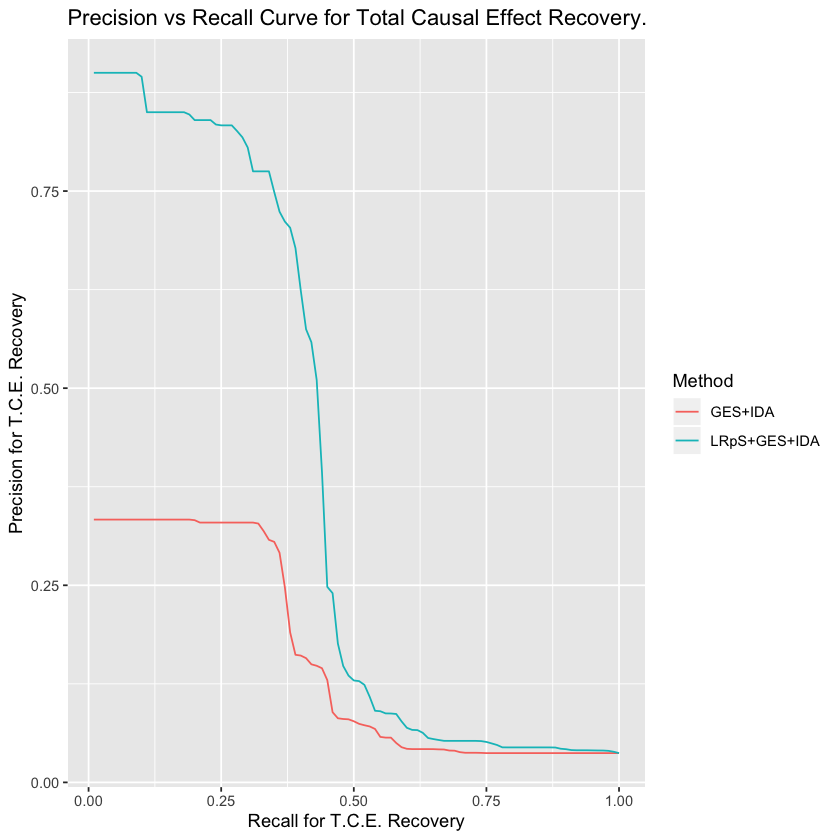

In [30]:
# Plot the results
d <- rbind(as.data.frame(lrps.ges.ida.pr), as.data.frame(ges.ida.pr))
d$Method <- c(rep("LRpS+GES+IDA", length(ges.ida.pr$x)),
              rep("GES+IDA", length(ges.ida.pr$x)))
pl <- ggplot(d, aes(x=x, y=y)) + geom_line(aes(colour=Method)) +
  xlab("Recall for T.C.E. Recovery") + ylab("Precision for T.C.E. Recovery") +
  ggtitle(paste("Precision vs Recall Curve for Total Causal Effect Recovery."))
pl